In [5]:
MODEL_ID = "a80a294f-12f8-4b27-8eac-9aad9a53ec8b"

MARKET1 = "DOW"
MARKET2 = "SPY"

PIPELINE_ID = "marketdirection"

In [6]:
#
# Get dataset from MI API #
#

import pandas

!pip install --upgrade '../../../../quantutils'
!pip install '../../../../quantutils/pylogmet'
#!pip install plotly
import quantutils.dataset.pipeline as ppl
from quantutils.api.bluemix import ObjectStore
from quantutils.api.marketinsights import MarketInsights

mi = MarketInsights('cred/MIOapi_cred.json')
objStore = ObjectStore('cred/object_storage_cred.json')

mkt1 = mi.get_dataset(MARKET1, PIPELINE_ID)
mkt2 = mi.get_dataset(MARKET1, PIPELINE_ID)

# Interleave (part of the "added insight" for this model)
mkt1, mkt2, isect = ppl.intersect(mkt1,mkt2)
dataset = ppl.interleave(mkt1,mkt2)

Processing /notebooks/quantutils
  Found existing installation: quantutils 1.0.0
    Uninstalling quantutils-1.0.0:
      Successfully uninstalled quantutils-1.0.0
  Running setup.py install for quantutils ... done
Processing /notebooks/quantutils/pylogmet


In [2]:
testSetLength = 430
training_set = dataset[:-(testSetLength)]
test_set = dataset[-(testSetLength):]          

In [7]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

##### Specific to the data ##
NUM_FEATURES = (2 * 4) + 1
NUM_LABELS = 2
#############################


##### #Define the architecture
HIDDEN_UNITS = 32

# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(tf.float32, shape=(None, NUM_FEATURES))
train_labels_node = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
lam = tf.placeholder(tf.float32)

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized. 
# TODO : These should be pulled from a config file

Theta1 = tf.Variable( tf.truncated_normal([HIDDEN_UNITS, (NUM_FEATURES)], stddev=0.1))

Theta2 = tf.Variable( tf.truncated_normal([NUM_LABELS, HIDDEN_UNITS],stddev=0.1))
bias2 = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))
    
print('Done')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Done


In [8]:
def model(X, Theta1, Theta2, bias):
    """The Model definition."""
    # Perceptron
    
    layer1 = tf.nn.sigmoid(tf.matmul(X, tf.transpose(Theta1)))
                        
    output = tf.nn.bias_add(tf.matmul(layer1, tf.transpose(Theta2)),bias)

    return output
    
print('Done')

Done


In [9]:
yhat = model(train_data_node, Theta1, Theta2, bias2)

# Change the weights by subtracting derivative with respect to that weight
loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=train_labels_node, logits=yhat))
# Regularization using L2 Loss function 
regularizer = tf.nn.l2_loss(Theta1) + tf.nn.l2_loss(Theta2)
reg = (lam / tf.to_float(tf.shape(train_labels_node)[0])) * regularizer
loss_reg = loss + reg

# Optimizer: 

# Gradient Descent
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss_reg, options={'maxiter':4000})
#update_weights = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Predictions
train_prediction = tf.sigmoid(yhat)

print('Done')

Done


In [6]:
# Keep track of the loss at each iteration so we can chart it later
J = []

def loss_callback():
    print "Recalc..."
    
def step_callback(params):
    J.append(params)
    
def sample(training_set, method="RANDOM", prop=.9, loo=0, boost = []): 
    if (method == "RANDOM"):
        training_set = training_set.sample(frac=1).reset_index(drop=True)
        idx = np.arange(0,len(training_set)) / float(len(training_set))
        return [training_set[idx<prop], training_set[idx>=prop]]
    elif (method == "LOO"):
        idx = np.array(range(0,len(training_set)))
        return [training_set[idx!=loo], training_set[idx==loo]]
    elif (method == "BOOTSTRAP"):
        idx = np.array(range(0,len(training_set)))
        sample = np.random.choice(idx, len(training_set), replace=True)
        return pandas.DataFrame(training_set.values[sample,:]), training_set[~np.in1d(idx, sample)]
    elif (method == "BOOSTING"):
        idx = np.array(range(0,len(training_set)))
        sample = np.random.choice(idx, len(training_set), replace=True, p=boost)
        return pandas.DataFrame(training_set.values[sample,:]), training_set[~np.in1d(idx, sample)]
    
def minimize(feed_dict, train=True):
    
    #optimizer.minimize(feed_dict=feed_dict, fetches=[loss_reg], loss_callback=loss_callback)
    if (train):
        optimizer.minimize(feed_dict=feed_dict)

    return loss.eval(feed_dict), train_prediction.eval(feed_dict)

def getSignals(predictions, data_y, threshold):
    signals = np.ones(len(data_y))
    a = np.argmax(predictions,axis=1) 
    b = np.argmax(data_y,axis=1)
    signals[a != b] = -1
    signals[(predictions < threshold).all(axis=1)] = 0
    return signals
    

def evaluate(predictions, data_y, threshold, majorityVote=False):
    
    a = np.argmax(predictions,axis=1)
    b = np.argmax(data_y,axis=1) 
    
    if (majorityVote):
        msk = a[1::2] == a[::2]
        msk = np.dstack([msk,msk]).flatten()
        a = a[msk]
        b = b[msk]
        predictions = predictions[msk]
    
    a = a[(predictions > threshold).any(axis=1)]
    b = b[(predictions > threshold).any(axis=1)]
        
    precision = np.float32(np.sum(a == b) / np.float32(b.shape[0]))
    recall = np.float32(np.sum(a == b) / np.float32(data_y.shape[0])) # Correct Recall
    recall = np.float32(b.shape[0]) / data_y.shape[0] # Number of Days traded
    F_score = (2.0 * precision * recall) / (precision + recall)
    return precision, recall, F_score

def predict(data_X, data_y, lam1, threshold):    
    loss, predictions = minimize({train_data_node: data_X, train_labels_node: data_y, lam: lam1}, train=False)
    precision, recall, F_score = evaluate(predictions, data_y, threshold)
    return loss, precision, recall, F_score, predictions
    

def train(train_dict, val_dict, test_dict, threshold, iterations=50, debug=True):
    
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[],
        "test_loss":[],
        "test_precision":[],
        "test_recall":[],
        "test_f":[],
        "test_predictions":[]
    }
    
    for i in range(0,iterations):
        
        for j in range(0, 50):
            
            # Create a new interactive session that we'll use in
            # subsequent code cells.
            s = tf.InteractiveSession()
            s.as_default()

            # Initialize all the variables we defined above.
            tf.global_variables_initializer().run()

            minimize(train_dict)
            train_loss, train_precision, train_recall, train_f, _ = predict(train_dict[train_data_node], train_dict[train_labels_node], train_dict[lam], threshold)

            if (train_loss < .65):
                print ".",
                metrics["train_loss"].append(train_loss)
                metrics["train_precision"].append(train_precision)
                metrics["train_recall"].append(train_recall)
                metrics["train_f"].append(train_f)

                val_loss, val_precision, val_recall, val_f, _= predict(val_dict[train_data_node], val_dict[train_labels_node], val_dict[lam], threshold)

                metrics["val_loss"].append(val_loss)
                metrics["val_precision"].append(val_precision)
                metrics["val_recall"].append(val_recall)
                metrics["val_f"].append(val_f)
                
                test_loss, test_precision, test_recall, test_f, test_predictions = predict(test_dict[train_data_node], test_dict[train_labels_node], test_dict[lam], threshold)

                metrics["test_loss"].append(test_loss)
                metrics["test_precision"].append(test_precision)
                metrics["test_recall"].append(test_recall)
                metrics["test_f"].append(test_f)
                metrics["test_predictions"] = test_predictions # Return the last set of predictions (could return the one with the best val score)
                break;
        
        if (j >= 50):
            print("ERROR : Failed to minimise function")
            
    results = {
        "train_loss": {"mean":np.nanmean(metrics["train_loss"]), "std":np.nanstd(metrics["train_loss"]), "values":metrics["train_loss"]},
        "train_precision": {"mean":np.nanmean(metrics["train_precision"]), "std":np.nanstd(metrics["train_precision"]), "values":metrics["train_precision"]},
        "train_recall": {"mean":np.nanmean(metrics["train_recall"]), "std":np.nanstd(metrics["train_recall"]), "values":metrics["train_recall"]},
        "train_f": {"mean":np.nanmean(metrics["train_f"]), "std":np.nanstd(metrics["train_f"]), "values":metrics["train_f"]},
        "val_loss": {"mean":np.nanmean(metrics["val_loss"]), "std":np.nanstd(metrics["val_loss"]), "values":metrics["val_loss"]},
        "val_precision":{"mean":np.nanmean(metrics["val_precision"]), "std":np.nanstd(metrics["val_precision"]), "values":metrics["val_precision"]},
        "val_recall": {"mean":np.nanmean(metrics["val_recall"]), "std":np.nanstd(metrics["val_recall"]), "values":metrics["val_recall"]},
        "val_f": {"mean":np.nanmean(metrics["val_f"]), "std":np.nanstd(metrics["val_f"]), "values":metrics["val_f"]},
        "test_loss": {"mean":np.nanmean(metrics["test_loss"]), "std":np.nanstd(metrics["test_loss"]), "values":metrics["test_loss"]},
        "test_precision":{"mean":np.nanmean(metrics["test_precision"]), "std":np.nanstd(metrics["test_precision"]), "values":metrics["test_precision"]},
        "test_recall": {"mean":np.nanmean(metrics["test_recall"]), "std":np.nanstd(metrics["test_recall"]), "values":metrics["test_recall"]},
        "test_f": {"mean":np.nanmean(metrics["test_f"]), "std":np.nanstd(metrics["test_f"]), "values":metrics["test_f"]},
        "test_predictions": metrics["test_predictions"],
    }
    
    print ".",
    if debug:
        print("Iterations : %d Lambda : %.2f, Threshold : %.2f" % (iterations, val_dict[lam], threshold))
        print("Training loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["train_loss"]["mean"], results["train_loss"]["std"],
               results["train_precision"]["mean"], results["train_precision"]["std"],
               results["train_recall"]["mean"], results["train_recall"]["std"],
               results["train_f"]["mean"], results["train_f"]["std"]))
        print("Validation loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["val_loss"]["mean"], results["val_loss"]["std"],
               results["val_precision"]["mean"], results["val_precision"]["std"],
               results["val_recall"]["mean"], results["val_recall"]["std"],
               results["val_f"]["mean"], results["val_f"]["std"]))
        print("Test loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["test_loss"]["mean"], results["test_loss"]["std"],
               results["test_precision"]["mean"], results["test_precision"]["std"],
               results["test_recall"]["mean"], results["test_recall"]["std"],
               results["test_f"]["mean"], results["test_f"]["std"]))

    return results

In [12]:
### 
### CROSS-VAL RANDOM SAMPLING
###

def bootstrapTrain(training_set, test_set, lamda, iterations, threshold, debug=False):

    metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[],
        "test_loss":[],
        "test_precision":[],
        "test_recall":[],
        "test_f":[],
        "test_predictions":[]
    }
    
    test_X, test_y = ppl.splitCol(test_set, NUM_FEATURES)

    for i in range(0, iterations):
        
        print ".",

        train_sample, val_sample = sample(training_set, method="BOOTSTRAP", loo=i)

        train_sample_X, train_sample_y = ppl.splitCol(train_sample, NUM_FEATURES)
        val_sample_X, val_sample_y = ppl.splitCol(val_sample, NUM_FEATURES)        

        results = train({train_data_node: train_sample_X, train_labels_node: train_sample_y, lam: lamda}, {train_data_node: val_sample_X, train_labels_node: val_sample_y, lam: lamda}, {train_data_node: test_X, train_labels_node: test_y, lam: lamda}, threshold, 1, True)

        metrics["train_loss"].append(results["train_loss"]["mean"])
        metrics["train_precision"].append(results["train_precision"]["mean"])
        metrics["train_recall"].append(results["train_recall"]["mean"])
        metrics["train_f"].append(results["train_f"]["mean"])
        metrics["val_loss"].append(results["val_loss"]["mean"])
        metrics["val_precision"].append(results["val_precision"]["mean"])
        metrics["val_recall"].append(results["val_recall"]["mean"])
        metrics["val_f"].append(results["val_f"]["mean"])
        metrics["test_loss"].append(results["test_loss"]["mean"])
        metrics["test_precision"].append(results["test_precision"]["mean"])
        metrics["test_recall"].append(results["test_recall"]["mean"])
        metrics["test_f"].append(results["test_f"]["mean"])
        metrics["test_predictions"].append(results["test_predictions"])  


    results = {
        "train_loss": {"mean":np.nanmean(metrics["train_loss"]), "std":np.nanstd(metrics["train_loss"]), "values":metrics["train_loss"]},
        "train_precision": {"mean":np.nanmean(metrics["train_precision"]), "std":np.nanstd(metrics["train_precision"]), "values":metrics["train_precision"]},
        "train_recall": {"mean":np.nanmean(metrics["train_recall"]), "std":np.nanstd(metrics["train_recall"]), "values":metrics["train_recall"]},
        "train_f": {"mean":np.nanmean(metrics["train_f"]), "std":np.nanstd(metrics["train_f"]), "values":metrics["train_f"]},
        "val_loss": {"mean":np.nanmean(metrics["val_loss"]), "std":np.nanstd(metrics["val_loss"]), "values":metrics["val_loss"]},
        "val_precision":{"mean":np.nanmean(metrics["val_precision"]), "std":np.nanstd(metrics["val_precision"]), "values":metrics["val_precision"]},
        "val_recall": {"mean":np.nanmean(metrics["val_recall"]), "std":np.nanstd(metrics["val_recall"]), "values":metrics["val_recall"]},
        "val_f": {"mean":np.nanmean(metrics["val_f"]), "std":np.nanstd(metrics["val_f"]), "values":metrics["val_f"]},
        "test_loss": {"mean":np.nanmean(metrics["test_loss"]), "std":np.nanstd(metrics["test_loss"]), "values":metrics["test_loss"]},
        "test_precision":{"mean":np.nanmean(metrics["test_precision"]), "std":np.nanstd(metrics["test_precision"]), "values":metrics["test_precision"]},
        "test_recall": {"mean":np.nanmean(metrics["test_recall"]), "std":np.nanstd(metrics["test_recall"]), "values":metrics["test_recall"]},
        "test_f": {"mean":np.nanmean(metrics["test_f"]), "std":np.nanstd(metrics["test_f"]), "values":metrics["test_f"]},
        "test_predictions": metrics["test_predictions"],
    }

    if debug:
        print("Iteration : %d Lambda : %.2f, Threshold : %.2f" % (i, lamda, threshold))
        print("Training loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["train_loss"]["mean"], results["train_loss"]["std"],
               results["train_precision"]["mean"], results["train_precision"]["std"],
               results["train_recall"]["mean"], results["train_recall"]["std"],
               results["train_f"]["mean"], results["train_f"]["std"]))
        print("Validation loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["val_loss"]["mean"], results["val_loss"]["std"],
               results["val_precision"]["mean"], results["val_precision"]["std"],
               results["val_recall"]["mean"], results["val_recall"]["std"],
               results["val_f"]["mean"], results["val_f"]["std"]))
        print("Test loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["test_loss"]["mean"], results["test_loss"]["std"],
               results["test_precision"]["mean"], results["test_precision"]["std"],
               results["test_recall"]["mean"], results["test_recall"]["std"],
               results["test_f"]["mean"], results["test_f"]["std"]))

    return results


In [13]:
### 
### BOOSTING
###

def boostingTrain(training_set, test_set, lamda, iterations, debug=False):

    metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[],
        "test_loss":[],
        "test_precision":[],
        "test_recall":[],
        "test_f":[],
        "test_predictions":[]
    }
    
    test_X, test_y = ppl.splitCol(test_set, NUM_FEATURES)
    train_X, train_y = ppl.splitCol(training_set, NUM_FEATURES)
    threshold = 0 # For boosting to work this must be 0
    boost = np.array([1.0/len(training_set)] * len(training_set))

    for i in range(0, iterations):
        
        print ".",

        train_sample, val_sample = sample(training_set, method="BOOSTING", boost=boost)

        train_sample_X, train_sample_y = ppl.splitCol(train_sample, NUM_FEATURES)
        val_sample_X, val_sample_y = ppl.splitCol(val_sample, NUM_FEATURES)        

        results = train({train_data_node: train_sample_X, train_labels_node: train_sample_y, lam: lamda}, {train_data_node: val_sample_X, train_labels_node: val_sample_y, lam: lamda}, {train_data_node: test_X, train_labels_node: test_y, lam: lamda}, threshold, 1, False)

        #Evaluate the results and calculate the odds of misclassification
        _, _, _, _, train_predictions = predict(train_X, train_y, lamda, threshold)
        precision = np.argmax(train_predictions,axis=1) == np.argmax(train_y,axis=1)
        epsilon = sum(boost[~precision]) 
        delta = epsilon / (1.0 - epsilon)
        boost[precision] = boost[precision] * delta
        boost = boost / sum(boost)
        
        
        metrics["train_loss"].append(results["train_loss"]["mean"])
        metrics["train_precision"].append(results["train_precision"]["mean"])
        metrics["train_recall"].append(results["train_recall"]["mean"])
        metrics["train_f"].append(results["train_f"]["mean"])
        metrics["val_loss"].append(results["val_loss"]["mean"])
        metrics["val_precision"].append(results["val_precision"]["mean"])
        metrics["val_recall"].append(results["val_recall"]["mean"])
        metrics["val_f"].append(results["val_f"]["mean"])
        metrics["test_loss"].append(results["test_loss"]["mean"])
        metrics["test_precision"].append(results["test_precision"]["mean"])
        metrics["test_recall"].append(results["test_recall"]["mean"])
        metrics["test_f"].append(results["test_f"]["mean"])
        metrics["test_predictions"].append(results["test_predictions"])
        


    results = {
        "train_loss": {"mean":np.nanmean(metrics["train_loss"]), "std":np.nanstd(metrics["train_loss"]), "values":metrics["train_loss"]},
        "train_precision": {"mean":np.nanmean(metrics["train_precision"]), "std":np.nanstd(metrics["train_precision"]), "values":metrics["train_precision"]},
        "train_recall": {"mean":np.nanmean(metrics["train_recall"]), "std":np.nanstd(metrics["train_recall"]), "values":metrics["train_recall"]},
        "train_f": {"mean":np.nanmean(metrics["train_f"]), "std":np.nanstd(metrics["train_f"]), "values":metrics["train_f"]},
        "val_loss": {"mean":np.nanmean(metrics["val_loss"]), "std":np.nanstd(metrics["val_loss"]), "values":metrics["val_loss"]},
        "val_precision":{"mean":np.nanmean(metrics["val_precision"]), "std":np.nanstd(metrics["val_precision"]), "values":metrics["val_precision"]},
        "val_recall": {"mean":np.nanmean(metrics["val_recall"]), "std":np.nanstd(metrics["val_recall"]), "values":metrics["val_recall"]},
        "val_f": {"mean":np.nanmean(metrics["val_f"]), "std":np.nanstd(metrics["val_f"]), "values":metrics["val_f"]},
        "test_loss": {"mean":np.nanmean(metrics["test_loss"]), "std":np.nanstd(metrics["test_loss"]), "values":metrics["test_loss"]},
        "test_precision":{"mean":np.nanmean(metrics["test_precision"]), "std":np.nanstd(metrics["test_precision"]), "values":metrics["test_precision"]},
        "test_recall": {"mean":np.nanmean(metrics["test_recall"]), "std":np.nanstd(metrics["test_recall"]), "values":metrics["test_recall"]},
        "test_f": {"mean":np.nanmean(metrics["test_f"]), "std":np.nanstd(metrics["test_f"]), "values":metrics["test_f"]},
        "test_predictions": metrics["test_predictions"],
        "weights":boost
    }

    if debug:
        print("Iteration : %d Lambda : %.2f, Threshold : %.2f" % (i, lamda, threshold))
        print("Training loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["train_loss"]["mean"], results["train_loss"]["std"],
               results["train_precision"]["mean"], results["train_precision"]["std"],
               results["train_recall"]["mean"], results["train_recall"]["std"],
               results["train_f"]["mean"], results["train_f"]["std"]))
        print("Validation loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["val_loss"]["mean"], results["val_loss"]["std"],
               results["val_precision"]["mean"], results["val_precision"]["std"],
               results["val_recall"]["mean"], results["val_recall"]["std"],
               results["val_f"]["mean"], results["val_f"]["std"]))
        print("Test loss : %.2f+/-%.2f, precision : %.2f+/-%.2f, recall : %.2f+/-%.2f, F : %.2f+/-%.2f" % 
              (results["test_loss"]["mean"], results["test_loss"]["std"],
               results["test_precision"]["mean"], results["test_precision"]["std"],
               results["test_recall"]["mean"], results["test_recall"]["std"],
               results["test_f"]["mean"], results["test_f"]["std"]))

    return results


In [84]:
##
## BOOSTING 
##

print "Training",
_, test_y = ppl.splitCol(test_set, NUM_FEATURES)
results = boostingTrain(training_set, test_set, .01, 20, True)
predictions =  np.nanmean(results["test_predictions"], axis=0)
#print results["weights"]
evaluate(predictions, test_y, .0)


Training . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Iteration : 19 Lambda : 0.01, Threshold : 0.00
Training loss : 0.24+/-0.04, precision : 0.75+/-0.12, recall : 1.00+/-0.00, F : 0.85+/-0.08
Validation loss : 1.90+/-0.24, precision : 0.54+/-0.02, recall : 1.00+/-0.00, F : 0.70+/-0.02
Test loss : 1.88+/-0.25, precision : 0.52+/-0.03, recall : 1.00+/-0.00, F : 0.68+/-0.02


(0.52093023, 1.0, 0.68501528884203555)

In [13]:
##
## BOOTSTRAP TRAINING
##

print "Training",
_, test_y = ppl.splitCol(test_set, NUM_FEATURES)
results = bootstrapTrain(training_set, test_set, .01, 20, .0, True)
predictions2 =  np.nanmean(results["test_predictions"], axis=0)
evaluate(predictions2, test_y, .0)


Training . . . Iterations : 1 Lambda : 0.01, Threshold : 0.00
Training loss : 0.30+/-0.00, precision : 0.89+/-0.00, recall : 1.00+/-0.00, F : 0.94+/-0.00
Validation loss : 1.31+/-0.00, precision : 0.58+/-0.00, recall : 1.00+/-0.00, F : 0.73+/-0.00
Test loss : 1.87+/-0.00, precision : 0.52+/-0.00, recall : 1.00+/-0.00, F : 0.68+/-0.00
. . . Iterations : 1 Lambda : 0.01, Threshold : 0.00
Training loss : 0.31+/-0.00, precision : 0.88+/-0.00, recall : 1.00+/-0.00, F : 0.94+/-0.00
Validation loss : 1.23+/-0.00, precision : 0.61+/-0.00, recall : 1.00+/-0.00, F : 0.76+/-0.00
Test loss : 1.53+/-0.00, precision : 0.51+/-0.00, recall : 1.00+/-0.00, F : 0.67+/-0.00
. . . Iterations : 1 Lambda : 0.01, Threshold : 0.00
Training loss : 0.32+/-0.00, precision : 0.87+/-0.00, recall : 1.00+/-0.00, F : 0.93+/-0.00
Validation loss : 1.39+/-0.00, precision : 0.56+/-0.00, recall : 1.00+/-0.00, F : 0.72+/-0.00
Test loss : 1.42+/-0.00, precision : 0.55+/-0.00, recall : 1.00+/-0.00, F : 0.71+/-0.00
. . . Iter

(0.5674419, 1.0, 0.7240356247830815)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in divide


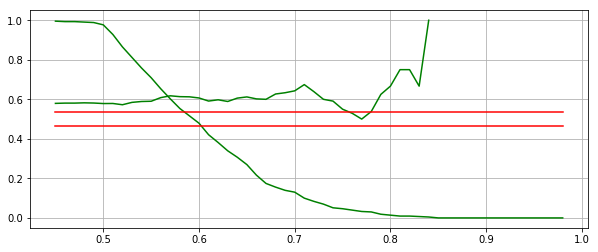

In [14]:
#####
# THRESHOLD PROFILE
# PLOTS PRECISION AND RECALL ACROSS VARYING THRESHOLD VALUES
# (Look for increasing recall to the point where precision causes recall to be non-significant for the sample size)
#####
p = []
r = [] 
p2 = [] 
r2 = [] 
b1 = []
b2 = []
x = np.arange(0.45, .99, 0.01)
for i in x:
    ##p.append(evaluate(predictions, test_y, i)[0])
    #r.append(evaluate(predictions, test_y, i)[1])
    p.append(evaluate(predictions, test_y[:len(predictions)], i)[0])
    r.append(evaluate(predictions, test_y[:len(predictions)], i)[1])
    b1.append(evaluate(np.column_stack((np.zeros(len(predictions)),np.ones(len(predictions)))), test_y[:len(predictions)], 0)[0])
    b2.append(evaluate(np.column_stack((np.ones(len(predictions)),np.zeros(len(predictions)))), test_y[:len(predictions)], 0)[0])

    
# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

#ax1.plot(x, p, color="blue")
#ax1.plot(x, r, color="blue")
ax1.plot(x, p, color="green")
ax1.plot(x, r, color="green")
ax1.plot(x, b1, color="red")
ax1.plot(x, b2, color="red")
plt.grid()
plt.show()


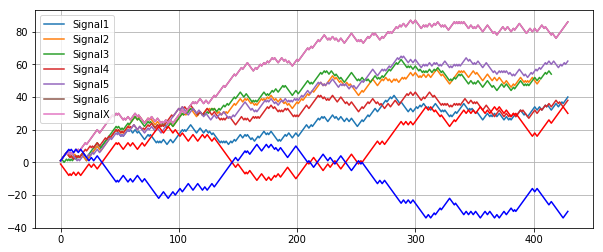

(0.6, 1.0, 0.7500000186264513)

In [23]:
threshold = .0
signals1 = getSignals(predictions1, test_y[:len(predictions1)], threshold)
signals2 = getSignals(predictions2, test_y[:len(predictions2)], threshold)
signals3 = getSignals(predictions3, test_y[:len(predictions3)], threshold)
signals4 = getSignals(predictions4, test_y[:len(predictions4)], threshold)
signals5 = getSignals(predictions5, test_y[:len(predictions5)], threshold)
signals6 = getSignals(predictions6, test_y[:len(predictions6)], threshold)
signals7 = getSignals(predictions, test_y[:len(predictions)], threshold)

baseline1 = np.column_stack((np.zeros(len(predictions)),np.ones(len(predictions))))
baseline2 = np.column_stack((np.ones(len(predictions)),np.zeros(len(predictions))))
baseline1_signals = getSignals(baseline1, test_y[:len(predictions)], 0)
baseline2_signals = getSignals(baseline2, test_y[:len(predictions)], 0)
if sum(baseline1_signals) > sum(baseline2_signals):
    baseline_signals = baseline1_signals 
else:
    baseline_signals = baseline2_signals
    
market = np.argmax(test_y[:len(predictions)], axis=1)
market[market==0] = -1

# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

#ax1.plot(x, p, color="blue")
#ax1.plot(x, r, color="blue")
plt1, = ax1.plot(np.cumsum(signals1), label="Signal1")
plt2, = ax1.plot(np.cumsum(signals2), label="Signal2")
plt3, = ax1.plot(np.cumsum(signals3), label="Signal3")
plt4, = ax1.plot(np.cumsum(signals4), label="Signal4")
plt5, = ax1.plot(np.cumsum(signals5), label="Signal5")
plt6, = ax1.plot(np.cumsum(signals6), label="Signal6")
plt7, = ax1.plot(np.cumsum(signals7), label="SignalX")
ax1.plot(np.cumsum(baseline_signals), color="red")
ax1.plot(np.cumsum(market), color="blue")
plt.grid()
plt.legend(handles=[plt1,plt2,plt3,plt4,plt5,plt6,plt7])
plt.show()

evaluate(predictions, test_y[:len(predictions)], threshold)

In [28]:
res = evaluate(predictions, test_y, .5, majorityVote=True)
print res

(1 - res[1]) * 430 / 2 / 215


(0.62318838, 0.64186046511627903, 0.6323866209946799)


0.35813953488372102

In [7]:
#########################################
## Load predictions and produce stats ###
#########################################
_, test_y = ppl.splitCol(test_set, NUM_FEATURES)
predictions = pandas.read_csv(objStore.get_file('Experiment2', 'results_new.csv'), header=None)
predictions = predictions.values#[:,1:]
initialTestValue = 0
print predictions.shape
print evaluate(predictions, test_y[initialTestValue:initialTestValue+len(predictions),:], .0)


(394, 2)
(0.52030456, 1.0, 0.6844741167322278)


In [23]:
predictions2 = predictions

In [31]:
predictions = np.concatenate((predictions, predictions2), axis=0)
predictions.shape


(430, 2)

In [106]:
pandas.DataFrame(predictions).to_csv("Experiment2_Boosting+LOO+FixedWindow_Results.csv", index=False, header=False)

In [7]:
predictions6 = pandas.read_csv("../Results/Experiment2_Boosting+LOO+FixedWindow_Results.csv", header=None).values
predictions5 = pandas.read_csv("../Results/Experiment2_Boosting+LOO+NoWindow_Results.csv", header=None).values
predictions4 = pandas.read_csv("../Results/Experiment2_Boosting_Results.csv", header=None).values
predictions3 = pandas.read_csv("../Results/Experiment2_Bootstrap+LOO+FixedWindow_Results.csv", header=None).values
predictions2 = pandas.read_csv("../Results/Experiment2_Bootstrap+LOO+NoWindow_Results.csv", header=None).values
predictions1 = pandas.read_csv("../Results/Experiment2_Bootstrap_Results.csv", header=None).values
predictions = predictions6

IOError: File ../Results/Experiment2_Boosting+LOO+FixedWindow_Results.csv does not exist

In [ ]:
#### LEARNING CURVES FOR TRAINING SET AND CROSS-VALIDATION SET 
###
train_losses = []
val_losses = [0]
perc_losses = [0]
tf.logging.set_verbosity(tf.logging.ERROR)

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "val_loss":[],
        "val_precision":[],
        "val_recall":[],
        "val_f":[]
    }

myLam = 0.0
THRESHOLD = 0

for i in range(10,train_X.shape[0]+1,10):
    
    results = train({train_data_node: train_X[:i,:], train_labels_node: train_y[:i,:], lam: myLam},
            {train_data_node: val_X, train_labels_node: val_y, lam: myLam},
             THRESHOLD,
              1
            )
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["val_loss"].append(results["val_loss"]["mean"])
    metrics["val_precision"].append(results["val_precision"]["mean"])
    metrics["val_recall"].append(results["val_recall"]["mean"])
    metrics["val_f"].append(results["val_f"]["mean"])
        
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
ax1.plot(x, np.array(metrics["train_loss"]).ravel())
ax1.plot(x, np.array(metrics["val_loss"]).ravel(),'r')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

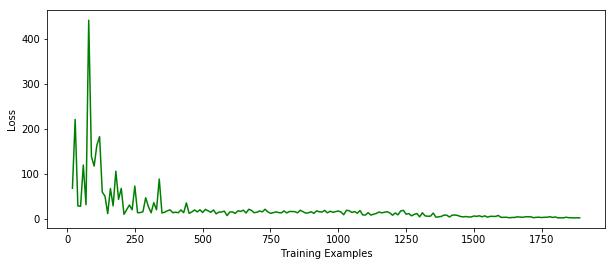

In [68]:
# Show the loss as the amount of data increases
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

x = np.array(range(0, len(metrics["val_loss"]))) * 10
#ax1.plot(x, np.array(train_losses).ravel())
#ax1.plot(x, np.array(val_losses).ravel(),'r')
ax1.plot(x[2:], (np.array(((np.array(metrics["val_loss"])) ))[2:]).ravel(),'g')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training Examples")
plt.show()

Training . . . . . . . . . . . . . . . Iteration : 4 Lambda : 0.00, Threshold : 0.00
Training loss : 0.27+/-0.03, precision : 0.89+/-0.02, recall : 1.00+/-0.00, F : 0.94+/-0.01
Validation loss : 2.44+/-0.46, precision : 0.55+/-0.02, recall : 1.00+/-0.00, F : 0.71+/-0.01
Test loss : 2.61+/-0.38, precision : 0.53+/-0.02, recall : 1.00+/-0.00, F : 0.69+/-0.02
Training . . . . . . . . . . . . . . . Iteration : 4 Lambda : 0.00, Threshold : 0.00
Training loss : 0.30+/-0.05, precision : 0.88+/-0.02, recall : 1.00+/-0.00, F : 0.93+/-0.01
Validation loss : 1.78+/-0.38, precision : 0.57+/-0.02, recall : 1.00+/-0.00, F : 0.72+/-0.02
Test loss : 2.05+/-0.48, precision : 0.52+/-0.02, recall : 1.00+/-0.00, F : 0.68+/-0.02
Training . . . . . . . . . . . . . . . Iteration : 4 Lambda : 0.00, Threshold : 0.00
Training loss : 0.26+/-0.03, precision : 0.91+/-0.02, recall : 1.00+/-0.00, F : 0.95+/-0.01
Validation loss : 1.87+/-0.24, precision : 0.56+/-0.02, recall : 1.00+/-0.00, F : 0.72+/-0.01
Test loss :

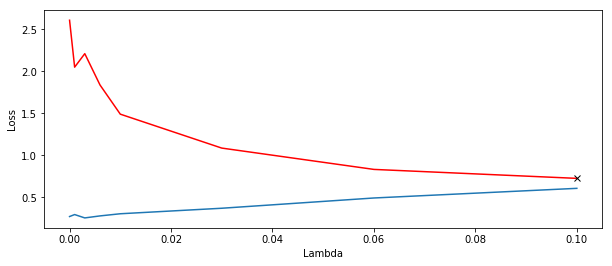

In [46]:
###
### LAMBDA OPTIMIZATION
###

tf.logging.set_verbosity(tf.logging.ERROR)

_, test_y = ppl.splitCol(test_set, NUM_FEATURES)

lams = [0.0, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]#, 0.3, 1.0, 3.0, 10.0]
#lams = np.arange(0.02,.04, .001)
#lams = [0.0, 0.01]

metrics = {
        "train_loss":[],
        "train_precision":[],
        "train_recall":[],
        "train_f":[],
        "test_loss":[],
        "test_precision":[],
        "test_recall":[],
        "test_f":[]
    }

for i in lams:
    
    print "Training",

    results = bootstrapTrain(training_set, test_set, i, 5, .0, True)
    
    metrics["train_loss"].append(results["train_loss"]["mean"])
    metrics["test_loss"].append(results["test_loss"]["mean"])
     

lam_opt = lams[np.argmin(metrics["test_loss"])]
print("Optimal value for lambda is %s" % lam_opt)
    
# Show the loss as the value of lambda changes
fig, (ax1) = plt.subplots(1, 1)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)

ax1.plot(lams, np.array(metrics["train_loss"]).ravel())
ax1.plot(lams, np.array(metrics["test_loss"]).ravel(),'r')
ax1.plot(lams[np.argmin(metrics["test_loss"])], metrics["test_loss"][np.argmin(metrics["test_loss"])], 'x', color='black')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Lambda")
plt.show()

In [9]:
## Put results to MI API

res1, res2 = ppl.deinterleave(predictions)
res1.index = isect[-len(res1):]
res2.index = isect[-len(res2):]

mi.put_predictions(res1, MARKET1, MODEL_ID, throttle=10, sleep=2, debug=False)
mi.put_predictions(res2, MARKET2, MODEL_ID, throttle=10, sleep=2, debug=False)

In [4]:
mi.get_predictions(MARKET1, MODEL_ID, start="2016-08-10 15:00:00", end="2016-08-20 15:00:00")

,0,1
2016-08-10 15:00:00,0.404936,0.584992
2016-08-11 15:00:00,0.434818,0.543098
2016-08-15 15:00:00,0.539887,0.451761
2016-08-16 15:00:00,0.509789,0.485636
2016-08-17 15:00:00,0.508589,0.517218
2016-08-18 15:00:00,0.273171,0.731172
2016-08-19 15:00:00,0.578864,0.429019


In [ ]:
res